In [ ]:
import pandas as pd
import plotly.express as px
import folium
import plotly.graph_objects as go
import geopandas as gpd
from shapely.geometry import Point, Polygon
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import folium
from shapely.geometry import mapping

In [ ]:
# Load boundary and device data
gurgaon_city_bounds = gpd.read_file('gurugram_boundary.json')
df_device_data = pd.read_csv('device_full_data.csv')
df_device_data['created_at'] = pd.to_datetime(df_device_data['created_at'])
df_device_data = df_device_data[['device_name', 'city', 'lat', 'long','location']].drop_duplicates().dropna()
df_device_data = df_device_data[df_device_data['city'] == 'Gurugram']
df_device_data['geometry'] = df_device_data.apply(lambda row: Point(row['long'], row['lat']), axis=1)
df_device_data = gpd.GeoDataFrame(df_device_data, geometry='geometry', crs='EPSG:4326')
df_device_data = df_device_data[df_device_data['geometry'].within(gurgaon_city_bounds['geometry'].values[0])]

# Load dynamic and static sensor data
dynamic = pd.read_csv('vayu_Gurugram_dynamic_sensor_data_November_2024.csv')
dynamic['data_created_time'] = pd.to_datetime(dynamic['data_created_time'])
dynamic['geometry'] = dynamic.apply(lambda row: Point(row['long'], row['lat']), axis=1)
dynamic = gpd.GeoDataFrame(dynamic, geometry='geometry', crs='EPSG:4326')
dynamic = dynamic[dynamic['geometry'].within(gurgaon_city_bounds['geometry'].values[0])]

static = pd.read_csv('vayu_Gurugram_static_sensor_data_November_2024.csv')
static = static[static['device_name'].isin(df_device_data['device_name'].unique())]
static['data_created_time'] = pd.to_datetime(static['data_created_time'])
static['geometry'] = static.apply(lambda row: Point(row['long'], row['lat']), axis=1)
static = gpd.GeoDataFrame(static, geometry='geometry', crs='EPSG:4326')
static = pd.merge(static,df_device_data[['device_name','location']],on='device_name')

In [ ]:
df_device_data.head(2)

device_name      city        lat       long               location  \
35     TARA020  Gurugram  28.466499  77.055355       Boosting Station   
38     TARA041  Gurugram  28.512396  77.025823  Mahindra Aura Society   

                    geometry  
35  POINT (77.05535 28.4665)  
38  POINT (77.02582 28.5124)

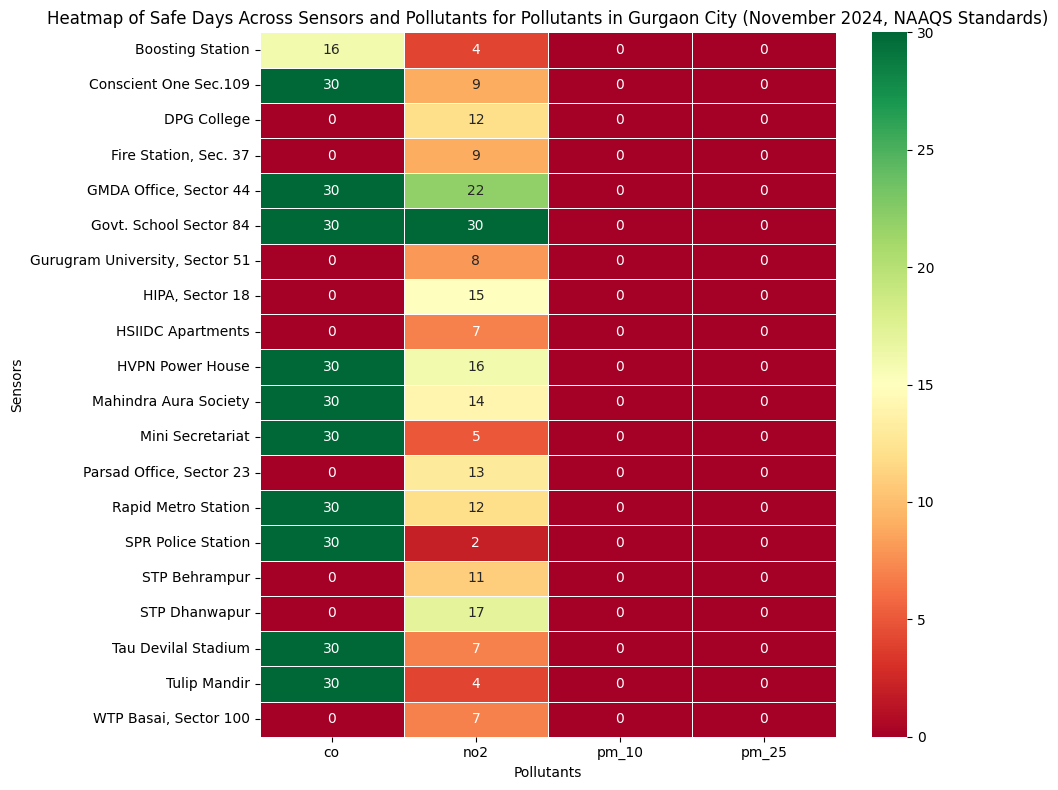

In [ ]:
# List of pollutants
pollutants = ['pm_25', 'pm_10', 'no2', 'co']

# Define WHO and Indian standards
standards = {
    'pm_25': {'WHO': 15, 'India': 60},
    'pm_10': {'WHO': 45, 'India': 100},
    'no2': {'WHO': 25, 'India': 80},
    'co': {'WHO': 4, 'India': 2}
}

# Ensure 'data_created_time' is in datetime format
static['data_created_time'] = pd.to_datetime(static['data_created_time'])

# Extract the date to group by daily intervals
static['date'] = static['data_created_time'].dt.date

# Calculate daily averages for each sensor
daily_avg = static.groupby(['device_name', 'location','date'])[pollutants].mean().reset_index()

# Initialize an empty DataFrame to store compliance summaries for all sensors
overall_compliance_summary = pd.DataFrame()

# Loop through each device
devices = daily_avg['device_name'].unique()
for device in devices:
    # Filter data for the current device
    device_level = daily_avg[daily_avg['device_name'] == device].copy()  # Explicitly copy to avoid warnings
    # Initialize a list to store compliance results for this device
    compliance = []

    for pollutant in pollutants:
        if pollutant in standards:
            who_limit = standards[pollutant]['WHO']
            india_limit = standards[pollutant]['India']

            # Add compliance flags for WHO and India standards using .loc
            device_level.loc[:, f'{pollutant}_WHO_safe'] = device_level[pollutant] <= who_limit if who_limit else None
            device_level.loc[:, f'{pollutant}_India_safe'] = device_level[pollutant] <= india_limit if india_limit else None

            # Count days under safe limits for each pollutant
            compliance.append({
                'device_name': device,
                'location':device_level['location'].values[0],
                'pollutant': pollutant,
                'WHO_safe_days': device_level[f'{pollutant}_WHO_safe'].sum() if who_limit else 'N/A',
                'India_safe_days': device_level[f'{pollutant}_India_safe'].sum() if india_limit else 'N/A'
            })

    # Append compliance results for this device to the overall compliance summary
    device_compliance_summary = pd.DataFrame(compliance)
    overall_compliance_summary = pd.concat([overall_compliance_summary, device_compliance_summary], ignore_index=True)

    #Heatmap: WHO Safe Days for Sensors and Pollutants
heatmap_data = overall_compliance_summary.pivot(index='location', columns='pollutant', values='WHO_safe_days')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="RdYlGn", fmt="d", linewidths=.5)
plt.title("Heatmap of Safe Days Across Sensors and Pollut for WHO Air Quality Thresholds in Gurgaon City (November 2024)")
plt.xlabel("Pollutants")
plt.ylabel("Sensors")
plt.tight_layout()
plt.show()

#Heatmap: NAAQS Safe Days for Sensors and Pollutants
heatmap_data = overall_compliance_summary.pivot(index='location', columns='pollutant', values='India_safe_days')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="RdYlGn", fmt="d", linewidths=.5)
plt.title("Heatmap of Safe Days Across Sensors and Pollutants for Pollutants in Gurgaon City (November 2024, NAAQS Standards)")
plt.xlabel("Pollutants")
plt.ylabel("Sensors")
plt.tight_layout()
plt.show()



In [ ]:
# Prepare city bounds
gurgaon_city_bounds = gurgaon_city_bounds.explode()

# Create grid
def create_grid(polygon, cell_size=0.005):
    min_x, min_y, max_x, max_y = polygon.bounds
    x_coords = np.arange(min_x, max_x, cell_size)
    y_coords = np.arange(min_y, max_y, cell_size)
    grid_cells = []
    for x in x_coords:
        for y in y_coords:
            cell = Polygon([(x, y), (x + cell_size, y), (x + cell_size, y + cell_size), (x, y + cell_size)])
            if cell.intersects(polygon):
                grid_cells.append(cell)
    return gpd.GeoDataFrame({'geometry': grid_cells})

grid = create_grid(gurgaon_city_bounds['geometry'].values[0])
grid.crs = gurgaon_city_bounds.crs

In [ ]:
# Aggregate pollutants and environmental variables
def aggregate_pollutants_with_env(grid, dynamic, static):
    grid_dynamic = gpd.sjoin(grid, dynamic, how='left', predicate='contains')
    grid_static = gpd.sjoin(grid, static, how='left', predicate='contains')

    pollutants = ['pm_25', 'pm_10', 'no2', 'co', 'temp', 'rh']
    for pollutant in pollutants:
        if pollutant in dynamic.columns:
            grid[f'{pollutant}_dynamic'] = grid_dynamic.groupby(grid_dynamic.index)[pollutant].mean()
        if pollutant in static.columns:
            grid[f'{pollutant}_static'] = grid_static.groupby(grid_static.index)[pollutant].mean()
        if f'{pollutant}_dynamic' in grid.columns and f'{pollutant}_static' in grid.columns:
            grid[f'{pollutant}_avg'] = grid[[f'{pollutant}_dynamic', f'{pollutant}_static']].mean(axis=1)
    return grid

grid = aggregate_pollutants_with_env(grid, dynamic, static)

In [ ]:
# Calculate Scalar-Based Composite Pollution Score
def calculate_scalar_based_score(grid):
    # Assign weights to pollutants (adjust as needed)
    weights = {'pm_25': 0.4, 'pm_10': 0.3, 'no2': 0.2, 'co': 0.1}

    # Normalize pollutant levels
    pollutants = ['pm_25_avg', 'pm_10_avg', 'no2_avg', 'co_avg']
    for pollutant in pollutants:
        grid[f'{pollutant}_norm'] = (grid[pollutant] - grid[pollutant].min()) / (grid[pollutant].max() - grid[pollutant].min())

    # Calculate scalar-based composite score
    grid['scalar_composite_score'] = (
        grid['pm_25_avg_norm'] * weights['pm_25'] +
        grid['pm_10_avg_norm'] * weights['pm_10'] +
        grid['no2_avg_norm'] * weights['no2'] +
        grid['co_avg_norm'] * weights['co']
    )
    return grid

# Apply the function
grid = calculate_scalar_based_score(grid)

# Normalize Scalar-Based Composite Score
grid['scalar_normalized_score'] = (grid['scalar_composite_score'] - grid['scalar_composite_score'].min()) / (
    grid['scalar_composite_score'].max() - grid['scalar_composite_score'].min()
)

In [ ]:
# Calculate Weighted Composite Pollution Score
def calculate_weighted_score(grid):
    weights = {'pm_25_exceed': 0.4, 'pm_10_exceed': 0.3, 'no2_exceed': 0.2, 'co_exceed': 0.1}
    grid['pm_25_exceed'] = (grid['pm_25_avg'] > 15).astype(int)
    grid['pm_10_exceed'] = (grid['pm_10_avg'] > 45).astype(int)
    grid['no2_exceed'] = (grid['no2_avg'] > 200).astype(int)
    grid['co_exceed'] = (grid['co_avg'] > 4).astype(int)
    grid['weighted_score'] = (
        grid['pm_25_exceed'] * weights['pm_25_exceed'] +
        grid['pm_10_exceed'] * weights['pm_10_exceed'] +
        grid['no2_exceed'] * weights['no2_exceed'] +
        grid['co_exceed'] * weights['co_exceed']
    )
    return grid

grid = calculate_weighted_score(grid)

# Normalize Weighted Score
grid['normalized_score'] = (grid['weighted_score'] - grid['weighted_score'].min()) / (grid['weighted_score'].max() - grid['weighted_score'].min())

In [ ]:
# Clustering with KMeans
def apply_kmeans(grid):
    features = grid[['pm_25_avg', 'pm_10_avg', 'no2_avg', 'co_avg', 'temp_avg', 'rh_avg']].fillna(0)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    kmeans = KMeans(n_clusters=4, random_state=0)
    grid['kmeans_cluster'] = kmeans.fit_predict(features_scaled)
    return grid

grid = apply_kmeans(grid)

In [ ]:
# Plot Correlation Matrix
def plot_correlations(grid):
    corr_data = grid[['pm_25_avg', 'pm_10_avg', 'no2_avg', 'co_avg', 'temp_avg', 'rh_avg']].fillna(0)
    corr_matrix = corr_data.corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
    plt.title("Correlation Matrix")
    plt.show()

plot_correlations(grid)

In [ ]:
# Function to visualize Composite Pollution Score with Rectangles
def visualize_composite_score_folium_rect(grid):
    # Create base map
    map_composite = folium.Map(location=[28.45, 77.03], zoom_start=11)

    # Add Composite Pollution Score rectangles
    for _, row in grid.iterrows():
        if not pd.isnull(row['normalized_score']):
            # Get grid polygon as GeoJSON format
            geo_json = mapping(row['geometry'])
            folium.Polygon(
                locations=[(coord[1], coord[0]) for coord in geo_json['coordinates'][0]],
                color='red' if row['normalized_score'] > 0.8 else 'orange' if row['normalized_score']>0.5 else 'grey',
                fill=True,
                fill_opacity=0.7,
                tooltip=f"Composite Score: {row['normalized_score']:.2f}"
            ).add_to(map_composite)

    return map_composite

# Function to visualize KMeans Clusters with Rectangles
def visualize_kmeans_clusters_folium_rect(grid):
    # Create base map
    map_clusters = folium.Map(location=[28.45, 77.03], zoom_start=11)

    # Define colors for clusters
    cluster_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']

    # Add KMeans Clusters rectangles
    for _, row in grid.iterrows():
        if not pd.isnull(row['kmeans_cluster']):
            geo_json = mapping(row['geometry'])
            folium.Polygon(
                locations=[(coord[1], coord[0]) for coord in geo_json['coordinates'][0]],
                color=cluster_colors[int(row['kmeans_cluster']) % len(cluster_colors)],
                fill=True,
                fill_opacity=0.7,
                tooltip=f"Cluster: {int(row['kmeans_cluster'])}"
            ).add_to(map_clusters)

    return map_clusters

# Function to visualize Scalar-Based Composite Score with Rectangles
def visualize_scalar_composite_score_folium_dynamic(grid):
    # Create base map
    map_scalar = folium.Map(location=[28.45, 77.03], zoom_start=11)

    # Get quantiles or define custom bins for the scalar scores
    bins = grid['scalar_normalized_score'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0]).tolist()
    colors = ['#ffffcc', '#ffeda0', '#feb24c', '#fd8d3c', '#e31a1c']  # Light to dark colors

    # Add Scalar-Based Composite Score rectangles
    for _, row in grid.iterrows():
        if not pd.isnull(row['scalar_normalized_score']):
            # Determine color based on value and bins
            value = row['scalar_normalized_score']
            for i in range(len(bins) - 1):
                if bins[i] <= value <= bins[i + 1]:
                    color = colors[i]
                    break

            # Get grid polygon as GeoJSON format
            geo_json = mapping(row['geometry'])
            folium.Polygon(
                locations=[(coord[1], coord[0]) for coord in geo_json['coordinates'][0]],
                color=color,
                fill=True,
                fill_opacity=0.7,
                tooltip=f"Scalar Score: {value:.2f}"
            ).add_to(map_scalar)

    return map_scalar

# Generate Folium Map with Dynamic Colors
dynamic_scalar_map = visualize_scalar_composite_score_folium_dynamic(grid)
composite_map_rect = visualize_composite_score_folium_rect(grid)
cluster_map_rect = visualize_kmeans_clusters_folium_rect(grid)

In [ ]:
composite_map_rect

In [ ]:
cluster_map_rect

In [ ]:
dynamic_scalar_map

In [ ]:
population = gpd.read_file('City_Pop.geojson')
population['pop'] = population['pop'].round()

In [ ]:
# Function to calculate risk zones based on distribution
def calculate_distribution_based_risk(grid, pollutant):
    """
    Calculate risk zones for a pollutant based on its distribution.
    Args:
        grid (GeoDataFrame): The grid data.
        pollutant (str): The pollutant column name (e.g., 'no2_avg').
    Returns:
        GeoDataFrame: Grid with a new column for pollutant risk score.
    """
    # Calculate quantiles for distribution-based categorization
    grid[f'{pollutant}_quantile'] = pd.qcut(grid[pollutant], q=4, labels=[1, 2, 3, 4])  # 4 risk levels
    return grid

# Apply the risk calculation for NO2
grid = calculate_distribution_based_risk(grid, 'no2_avg')

# Function to visualize pollutant risk zones with population overlay
def visualize_distribution_based_risk_folium(grid, population, pollutant):
    """
    Visualize distribution-based pollutant risk zones using Folium with population overlay.
    Args:
        grid (GeoDataFrame): The grid data with pollutant risk levels.
        population (GeoDataFrame): Population data with coordinates and population count.
        pollutant (str): The pollutant column name (e.g., 'no2_avg').
    """
    # Create base map
    map_pollutant = folium.Map(location=[28.45, 77.03], zoom_start=11)

    # Define colors for risk levels (1: Low, 4: High)
    risk_colors = {
        1: '#FFCCCC',  # Very Light Red
        2: '#FF9999',  # Light Red
        3: '#FF6666',  # Medium Red
        4: '#FF3333',  # Dark Red
    }

    # Add risk zones to the map
    for _, row in grid.iterrows():
        if not pd.isnull(row[f'{pollutant}_quantile']):
            color = risk_colors[int(row[f'{pollutant}_quantile'])]

            # Get grid polygon as GeoJSON format
            geo_json = mapping(row['geometry'])
            folium.Polygon(
                locations=[(coord[1], coord[0]) for coord in geo_json['coordinates'][0]],
                color=color,
                fill=True,
                fill_opacity=0.7,
                tooltip=f"{pollutant.capitalize()} Risk Level: {int(row[f'{pollutant}_quantile'])}"
            ).add_to(map_pollutant)

    # Add population points with opacity based on population size
    max_pop = population['pop'].max()  # Maximum population value for normalization
    for _, row in population.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['long']],
            radius=4,
            color=None,
            fill=True,
            fill_color='blue',
            fill_opacity=row['pop'] / max_pop,  # Opacity scaled by population size
            tooltip=f"Population: {int(row['pop'])}"
        ).add_to(map_pollutant)

    return map_pollutant

# Generate Folium Map with Population Overlay
no2_population_map = visualize_distribution_based_risk_folium(grid, population, 'no2_avg')
# Display the map (uncomment to view in Jupyter)
no2_population_map


In [ ]:
test = gpd.sjoin(population,grid,predicate='within')[['pm_25_avg_quantile','pop']].dropna()
test = test.groupby('pm_25_avg_quantile')['pop'].sum().reset_index()
test['%'] = test['pop']*100/population['pop'].sum()
test

<ipython-input-416-1429d62385e5>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



pm_25_avg_quantile       pop          %
0                  1  102531.0   8.079166
1                  2  130760.0  10.303535
2                  3  143631.0  11.317735
3                  4  109394.0   8.619952

In [ ]:
companies_data = gpd.read_file('/high_priority_companies.geojson')

In [ ]:
companies_data.head(2)

CIN                               CompanyName  \
0  U10728HR2021PTC093343               ORIAN COALS PRIVATE LIMITED   
1  U14101HR1997PTC058683  POOJA MINING AND MARBLES PRIVATE LIMITED   

  CompanyROCcode CompanyRegistrationdate_date  \
0      ROC Delhi                   2021-03-03   
1      ROC Delhi                   1997-08-01   

                           Registered_Office_Address CompanyStatus  \
0  F-BLOCK , NEAR MANDIR GATE, SUNCITY, SECTOR 54...        Active   
1  Second Floor H.No. K-45, Mayfield Garden,   Se...        Active   

  CompanyIndustrialClassification  latitude_mapbox  longitude_mapbox  \
0              Mining & Quarrying        28.434615         77.104576   
1              Mining & Quarrying        28.424040         77.068388   

                    geometry  
0  POINT (77.10458 28.43462)  
1  POINT (77.06839 28.42404)

In [ ]:
def visualize_regulatory_compliance_map(grid, companies_df, pollutant):
    """
    Create a Folium map showing pollution risk zones and company clusters.

    Args:
        grid (GeoDataFrame): Grid data with pollutant risk levels
        companies_df (DataFrame): DataFrame with company locations and metadata
        pollutant (str): The pollutant column name (e.g., 'no2_avg')

    Returns:
        folium.Map: Interactive map with risk zones and company clusters
    """
    # Create base map centered on the area of interest
    base_map = folium.Map(location=[28.45, 77.03],
                         zoom_start=11,
                         tiles='CartoDB positron')

    # Define colors for risk levels (1: Low, 4: High)
    risk_colors = {
        1: '#FFCCCC',  # Very Light Red
        2: '#FF9999',  # Light Red
        3: '#FF6666',  # Medium Red
        4: '#FF3333'   # Dark Red
    }

    # Add Google Satellite as an optional tile layer
    folium.TileLayer(
        tiles="https://{s}.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
        attr="Google",
        name="Google Satellite",
        subdomains=["mt0", "mt1", "mt2", "mt3"],
    ).add_to(base_map)

    # Add risk zones to the map
    for _, row in grid.iterrows():
        if not pd.isnull(row[f'{pollutant}_quantile']):
            color = risk_colors[int(row[f'{pollutant}_quantile'])]

            # Get grid polygon as GeoJSON format
            geo_json = mapping(row['geometry'])

            # Add polygon to map
            folium.Polygon(
                locations=[(coord[1], coord[0]) for coord in geo_json['coordinates'][0]],
                color=color,
                fill=True,
                fill_opacity=0.7,
                tooltip=f"{pollutant.capitalize()} Risk Level: {int(row[f'{pollutant}_quantile'])}"
            ).add_to(base_map)

    # Create a marker cluster group
    marker_cluster = MarkerCluster(
        name='Companies',
        overlay=True,
        control=True,
        icon_create_function=None
    )

    # Add company markers to the cluster
    for _, company in companies_df.iterrows():
        # Create popup content with company information
        popup_content = f"""
        <div style='width: 200px'>
            <b>Company:</b> {company['CompanyName']}<br>
            <b>Industry:</b> {company['CompanyIndustrialClassification']}<br>
            <b>Address:</b>{company['Registered_Office_Address']}<br>
        </div>
        """

        # Add marker to cluster
        folium.Marker(
            location=[company['latitude_mapbox'], company['longitude_mapbox']],
            popup=folium.Popup(popup_content, max_width=300)
        ).add_to(marker_cluster)

    # Add the marker cluster to the map
    marker_cluster.add_to(base_map)

    # Add a layer control
    folium.LayerControl().add_to(base_map)

    return base_map


# Create the map
regulatory_map = visualize_regulatory_compliance_map(grid, companies_data, 'pm_25_avg')
regulatory_map